In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [2]:
# 파일 불러오기

review_df = pd.read_csv('./MK_review_proceed_data.csv', encoding='utf-8', index_col=0) # df_review는 전체년도 리뷰 크롤링 파일
review_df.head(1)

,date,review,tokenized_review,tokenized_removed_review,reviews_for_vectorize,noun_tokenized_review,noun_tokenized_removed_review,noun_reviews_for_vectorize,rating,label
0,2023-09-10,상세 설명에 들어가지 않아도 검색 결과에서 중량과 가격이 바로 확인되면 더 편리하겠습니다,"['상세', '설명', '에', '들어가지', '않아도', '검색', '결과', '...","['상세', '설명', '들어가지', '않아도', '검색', '결과', '중량', ...",상세 설명 들어가지 않아도 검색 결과 중량 가격 확인 되면 더 편리하겠습니다,"['상세', '설명', '검색', '결과', '중량', '가격', '바로', '확인...","['상세', '설명', '검색', '결과', '중량', '가격', '확인', '더']",상세 설명 검색 결과 중량 가격 확인 더,5,1.0


Fitting 5 folds for each of 1 candidates, totalling 5 fits
finish


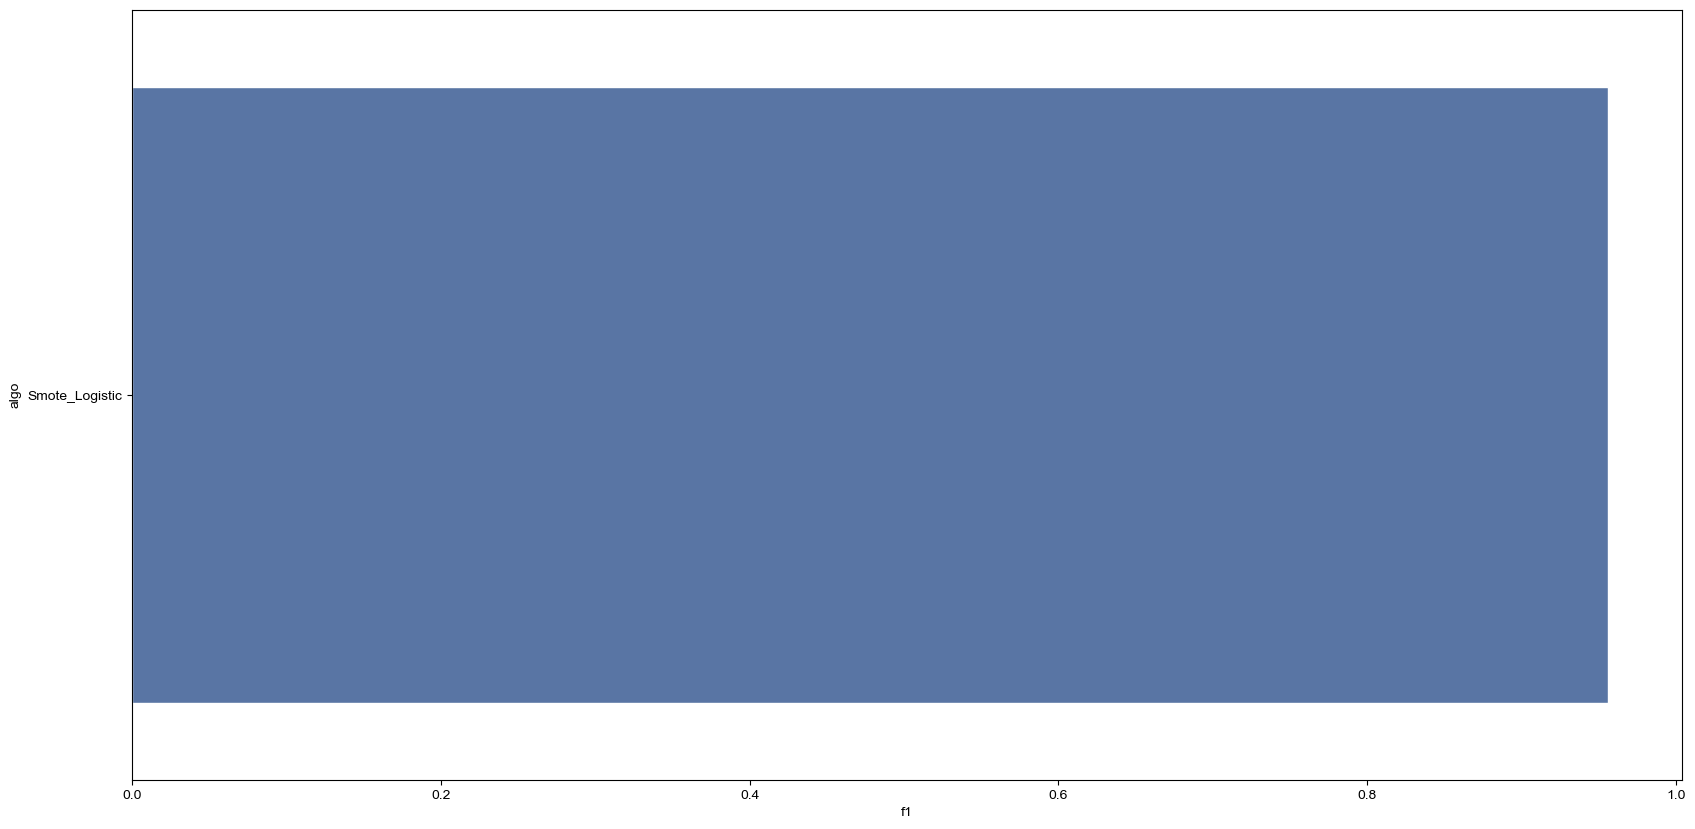

In [4]:
##### model
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression

y_train_F = []
y_test_T = []
y_test_F = []

##### sampling
from imblearn.over_sampling import SMOTE

##### pipeline
from imblearn.pipeline import Pipeline


##### confusion_matrix
from sklearn.metrics import confusion_matrix

##### dataset
X = review_df['reviews_for_vectorize']; y = review_df['label']


##### split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


##### cross-validation
skfold = StratifiedKFold(n_splits=5)


##### pipeline model
pipe_Smote_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('sampling', SMOTE(random_state=12)),
                ('fit', LogisticRegression(solver='saga'))])


##### set grid params
grid_params_Smote_Logistic = [{
    "sampling__sampling_strategy" : [0.3],
    "sampling__k_neighbors" : [3],
    "vec__min_df" : [1],
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]


##### fit
pipe = [pipe_Smote_Logistic ]
params = [grid_params_Smote_Logistic]

jobs = 20

grid_dict = {
    0: 'Smote_Logistic',
            }

model_object = {}; model_acc = {}; model_roc_auc = {}; model_f1 = {}; model_best_params = {}

#1. scoring = 'neg_mean_absolute_error' 로 설정.
# 일반적으로 scoring을 값이 클 수록 모델 성능이 좋은 것으로 사이킷런에서 인식하는데, 
# mae는 값이 클 수록 모델 성능이 저하되는 것이므로 Negative 키워드를 붙여서 사용

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold,
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    
    y_pred_train = search.predict(X_train)
    y_pred_test = search.predict(X_test)
       
    model_object[grid_dict.get(idx)] = search
    model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred_test)  
    model_roc_auc[grid_dict.get(idx)] = roc_auc_score(y_test, y_pred_test)
    model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred_test)

    model_confM_train = confusion_matrix(y_train, y_pred_train) # (X_test -> y_pred)
    model_confM_test = confusion_matrix(y_test, y_pred_test) # (X_test -> y_pred)

    model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [22]:
model_acc

{'Smote_Logistic': 0.928476821192053}

In [23]:
model_f1

{'Smote_Logistic': 0.9561451001624255}

In [24]:
model_roc_auc

{'Smote_Logistic': 0.8638165205580937}

## 혼동행렬 train 데이터 기준

In [44]:
cm_train = model_confM_train
cm_train

array([[1645,  133],
       [  92, 7186]], dtype=int64)

In [51]:
cm_train_acc = (cm_train[0][0] + cm_train[1][1]) / (cm_train[0][0] + cm_train[1][0] + cm_train[0][1] + cm_train[1][1]) #정확도

cm_train_prec_T = (cm_train[0][0]) / (cm_train[0][0] + cm_train[0][1]) #정밀도
cm_train_prec_F = (cm_train[1][1]) / (cm_train[1][1] + cm_train[1][0]) #정밀도

cm_train_recall_T = (cm_train[0][0]) / (cm_train[0][0] + cm_train[1][0]) #재현율
cm_train_recall_F = (cm_train[1][1]) / (cm_train[1][1] + cm_train[0][1]) #재현율

cm_train_f1_T = 2*((cm_train_prec_T*cm_train_recall_T)/(cm_train_prec_T+cm_train_recall_T))
cm_train_f1_F = 2*((cm_train_prec_F*cm_train_recall_F)/(cm_train_prec_F+cm_train_recall_F))

print("Train Data Accuracy :  ", round(cm_train_acc,2))
print("Train Data precision : ", round(cm_train_prec_T,2),'  (부정 :', round(cm_train_prec_F,2), ')')
print("Train Data recall :    ", round(cm_train_recall_T,2), '  (부정 :',round(cm_train_recall_F,2), ')')
print("Train Data f1-score :  ", round(cm_train_f1_T,2), '  (부정 :',round(cm_train_f1_F,2), ')')

Train Data Accuracy :   0.98
Train Data precision :  0.93   (부정 : 0.99 )
Train Data recall :     0.95   (부정 : 0.98 )
Train Data f1-score :   0.94   (부정 : 0.98 )


## 혼동행렬 test 데이터 기준

In [5]:
cm_test = model_confM_test
cm_test

array([[ 337,  108],
       [  54, 1766]], dtype=int64)

In [53]:
cm_test_acc = (cm_test[0][0] + cm_test[1][1]) / (cm_test[0][0] + cm_test[1][0] + cm_test[0][1] + cm_test[1][1]) #정확도

cm_test_prec_T = (cm_test[0][0]) / (cm_test[0][0] + cm_test[0][1]) #정밀도
cm_test_prec_F = (cm_test[1][1]) / (cm_test[1][1] + cm_test[1][0]) #정밀도

cm_test_recall_T = (cm_test[0][0]) / (cm_test[0][0] + cm_test[1][0]) #재현율
cm_test_recall_F = (cm_test[1][1]) / (cm_test[1][1] + cm_test[0][1]) #재현율

cm_test_f1_T = 2*((cm_test_prec_T*cm_test_recall_T)/(cm_test_prec_T+cm_test_recall_T))
cm_test_f1_F = 2*((cm_test_prec_F*cm_test_recall_F)/(cm_test_prec_F+cm_test_recall_F))

print("Train Data Accuracy :  ", round(cm_test_acc,2))
print("Train Data precision : ", round(cm_test_prec_T,2),'  (부정 :', round(cm_test_prec_F,2), ')')
print("Train Data recall :    ", round(cm_test_recall_T,2), '  (부정 :',round(cm_test_recall_F,2), ')')
print("Train Data f1-score :  ", round(cm_test_f1_T,2), '  (부정 :',round(cm_test_f1_F,2), ')')

Train Data Accuracy :   0.93
Train Data precision :  0.76   (부정 : 0.97 )
Train Data recall :     0.86   (부정 : 0.94 )
Train Data f1-score :   0.81   (부정 : 0.96 )


In [6]:
cm_test_acc_1 = (cm_test[0][0]) / (cm_test[0][0] + cm_test[0][1]) #정확도
cm_test_acc_0 = (cm_test[1][1]) / (cm_test[1][0] + cm_test[1][1]) #정확도
cm_test_acc_1,cm_test_acc_0

(0.7573033707865169, 0.9703296703296703)